# オークンの法則とフィリップス曲線

<div name="html-admonition" style="font-size: 0.8em">
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translation" style="color:#ffffff;background-color:#008080; height:25px" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/> in English or the language of your choice.
</div><br>

In [1]:
import japanize_matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

# numpy v1の表示を使用
np.set_printoptions(legacy='1.21')
# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

## はじめに

前章では経済のデータを人の「言動」に例えて説明したが，その比喩をもう少し考えてみよう。「言動」にはパターンがあり，その人の心を映し出しているとも考えられる。例えば，心の優しい人は電車やバスで重い荷物を持つ老人や小さな子を持つ女性に席を譲る回数が多いかも知れない。「あの子が好きだ！」とは決して口に出さない男の子でも，その思いを示唆するような発言や行動があるかも知れない。同じように，経済の「真のメカニズム」の反映としてデータには何らかのパターンが現れる。そのパターンを見つけることに経済学者は時間を割いてきたし，見出したパターンの中には経済を理解する上で非常に重要なヒント隠されている場合がある。ここでは代表的な次のデータのパターンを考える。
* オークンの法則
* フィリップス曲線

マクロ経済学を勉強した人にとっては必ずと言っていいほど，知名度が高いデータのパターンではないだろうか。これらから「真のメカニズム」の動きが垣間見える事になる。

一方で「真のメカニズム」は不変ではないかも知れない。経済は人が営む活動であり，人が変われば「真のメカニズム」も影響を受けると考えられる。技術進歩（例えば，ビットコイン）や価値観の変化（例えば，「昭和の価値観」から「平成・令和の価値観」への移り変わり），政府・日銀の政策やコロナ禍などの大きなショックは人の行動の変化に影響すると考えるのが自然である。例えば，2020年代の「真のメカニズム」は1970年代のそれとは異なる可能性を拭えない。データを見る際は，そのような変化がないかを注意深く見ることも重要になるだろう。

## オークンの法則

### 説明

この節で使用する記号：
* $Y_t$：GDP
* $\bar{Y}_t$：産出量の自然率水準（もしくは長期的GDP、潜在的GDP）
* $u_t$：失業率
* $\bar{u}_t$：自然失業率（もしくは長期的失業率）

オークンの法則は経験則として次の関係を表す。

$$
\frac{Y_t-\bar{Y}_t}{\bar{Y}_t}=-b\left( u_t-\bar{u}_t\right),\quad b>0
$$ (eq:11-okun)

左辺はGDPの自然率水準からの乖離率（自然率水準を何％上回るかを示す）であり，右辺は失業率の自然率からの乖離（自然失業率を何％ポイント上回るかを示す）である。即ち，GDPと失業率の長期的な値からの乖離には負の関係が存在することを意味している。労働者が生産投入といこと考えると，直感的にも受け入れ易い関係ではないだろうか。では失業率の乖離が1%ポイント上昇するとGDPの乖離率は何%減少するのだろうか。この問いについては，データを使いパラメータ`b`を推定する必要がる。難しい点は、$\bar{Y}_t$と$\bar{u}_t$が観測されないため推定する必要があることである。この点を回避するために、オークンの法則を変数の変化で表す場合もあるが、ここでは上の式を考える。$\bar{Y}_t$と$\bar{u}_t$の推定には様々な洗練された手法があるが、ここでは簡便的にHodrick–Prescottフィルターを使って計算したトレンドを$\bar{Y}$と$\bar{u}$とし，トレンドからの乖離を上の式の左辺と右辺に使う。

以前使ったデータを使うが，次の節でインフレ率について扱うので３つの変数`gdp`，`unemployment_rate`，`inflation`を読み込むことにする。

In [2]:
df = py4macro.data('jpn-q').loc[:,['gdp','unemployment_rate','inflation']]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 1980-01-01 to 2023-10-01
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gdp                176 non-null    float64
 1   unemployment_rate  176 non-null    float64
 2   inflation          176 non-null    float64
dtypes: float64(3)
memory usage: 5.5 KB


### 失業率の特徴

(sec:11-unemployment)=
### 失業率の特徴

ここでは失業率の特徴を考える。まず図示してみよう。

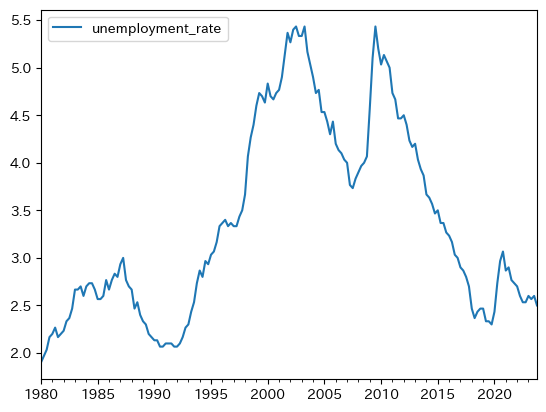

In [4]:
df.plot(y='unemployment_rate')
pass

最初に気づく点は，[前章](chap:10-gdp)で説明した持続性（変化が正（もしくは負）であれば正（もしくは負）の期間が続く傾向にある特徴）が高いとことである。実際，メソッド`.autocorr()`を使い自己相関係数を計算すると非常に高い値が返される。

In [5]:
df['unemployment_rate'].autocorr()

0.9919383533843956

次に，GDPのトレンドからの乖離（％）と失業率のトレンドからの乖離（％ポイント）を比べてみる。まず失業に関する変数を作成するが，対数を取らずに差分をトレンドからの乖離とする。

In [6]:
df['u_rate_trend'] = py4macro.trend(df['unemployment_rate'])
df['u_rate_cycle'] = df['unemployment_rate'] - df['u_rate_trend']

ここで作成した変数は次の変数を表している。
* `unemployment_rate_cycle`：$u_t-\bar{u}_t$
* $\bar{u}_t$：トレンド失業率

次にGDPのトレンドからの乖離率を計算しよう。
* `gdp_cycle`：$\dfrac{Y_t}{\bar{Y}_t}-1
                \approx
                \log\left(\dfrac{Y_t}{\bar{Y}_t}\right)
                =\log(Y_t) - \log(\bar{Y}_t)
                $
* $\bar{Y}_t$：トレンドGDP

In [7]:
df['gdp_cycle'] = 100*( 
                       np.log(df['gdp']) - py4macro.trend( np.log(df['gdp']) )
                      )

GDPの乖離と重ねて動きを確認してみる。

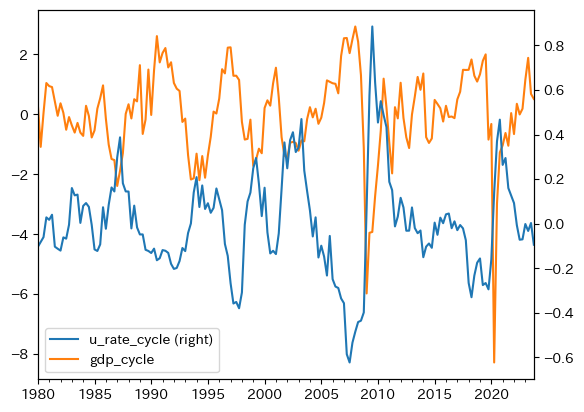

In [8]:
df.loc[:,['u_rate_cycle','gdp_cycle']].plot(secondary_y='u_rate_cycle')
pass

概ね逆方向に上下していることがわかる。またバブル景気の崩壊後やリーマン・ショック後に，２変数は逆方向に大きく動いていることも確認できる。相関度を確かめるために，`df`のメソッド`corr()`を使い相関係数を計算しよう。

In [9]:
df.loc[:,['u_rate_cycle','gdp_cycle']].corr()

,u_rate_cycle,gdp_cycle
u_rate_cycle,1.000000,-0.625012
gdp_cycle,-0.625012,1.000000


右上と左下の値が２変数の相関係数であり，値は約`-0.63`は強い逆相関を意味する。

また上の図から持続性が高いことが伺える。自己相関係数を計算してみよう。

In [10]:
df['gdp_cycle'].autocorr()

0.6974503788764269

In [11]:
df['u_rate_cycle'].autocorr()

0.8747098429841068

両変数ともトレンドからの乖離は持続性が非常に高いと言える。

### 回帰分析

では実際に式[](eq:11-okun)のスロープ変数$b$を推定してみよう。


In [12]:
formula = 'gdp_cycle ~ u_rate_cycle'   # 1
model = smf.ols(formula, data=df)      # 2
result = model.fit()                   # 3

```{admonition} コードの説明
:class: dropdown

1. 回帰式を文字列で作成し変数`formula`に割り当てる。
2. `smf`の関数`.ols`を使い最小二乗法の準備をし，変数`model`に割り当てる。
    * 引数は(1)の`formula`と`data`に使用する`DataFrame`（ここでは`df`）を指定する。
3. `model`のメソッド`.fit()`を使い自動計算し，その結果を`result`に割り当てる。
```

`result`のメソッド`.summary()`を使い結果を表として表示しよう。

In [13]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gdp_cycle   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     111.5
Date:                Mon, 19 Aug 2024   Prob (F-statistic):           1.84e-20
Time:                        22:30:47   Log-Likelihood:                -275.03
No. Observations:                 176   AIC:                             554.1
Df Residuals:                     174   BIC:                             560.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      2.43e-11      0.088   2.78e-10   

表の中段から次のことがわかる。
* 定数項の推定値は非常に小さい。即ち、失業率の乖離がゼロある場合、GDPの乖離率もぜろになることを示しており、定数項がない式[](eq:11-okun)と整合的であることわかる。
* パラメータ`b`の推定値は負の値となっていおり、失業率が自然失業率を上回るとGDP乖離率は減少することが確認できる。

＜コメント＞
* Durbin-Watson比は誤差項に正の自己相関が疑われことを示しており，$t$検定の解釈には注意が必要となるが，この点ついての議論は割愛する。

回帰分析の結果を踏まえると，失業率の乖離が`x`％ポイントの場合にGDPのトレンドからの乖離率（％）を計算する関数は次のようになる。

In [14]:
def growth_deviation(x):
    
    g = result.params.iloc[0]+result.params.iloc[1]*x
    print(f'失業率の乖離が{x:.1f}％ポイントの場合のGDPのトレンドからの乖離率は約{g:.2f}です。')

`x`が１％ポイントの場合を考えよう。

In [15]:
growth_deviation(1)

失業率の乖離が1.0％ポイントの場合のGDPのトレンドからの乖離率は約-4.06です。


この値を解釈してみよう。失業率が1％ポイント乖離するとしよう。GDPの乖離率は約`-4.1`％になることを示しているが、この値は非常に大きい。例えば、上のプロットで示したGDPのトレンドからの乖離率を考えてみよう。バブル崩壊時の乖離率は約`2.6`％，リーマン・ショック時では約`6`％，コロナ禍では`7.7`％である。これは日本の雇用制度を反映していると考えられる。またトレンドを計算する際に使ったHodrick–Prescottフィルターの影響もあるだろう。

次に、標本の散布図に回帰直線を重ねて表示してみる。まず`result`の属性`.fittedvalues`を使い非説明変数の予測値を抽出することができるので、`df`に`fitted`のラベルを使って新たな列として追加する。

In [16]:
df['fitted_okun'] = result.fittedvalues

図を重ねて表示する。

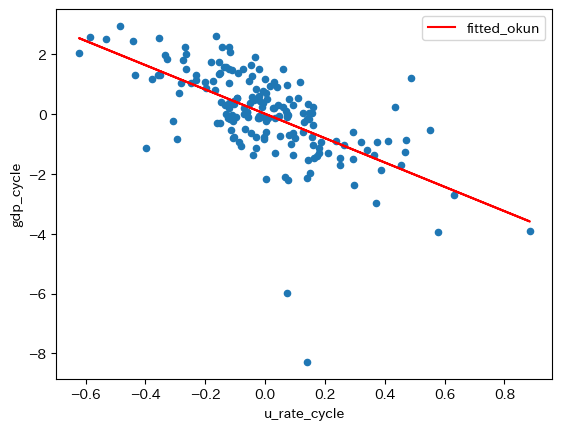

In [17]:
ax_ = df.plot.scatter(x='u_rate_cycle',
                      y='gdp_cycle')

df.plot(x='u_rate_cycle',
        y='fitted_okun',
        color='red',
        ax=ax_)
pass

````{note}
係数の推定値は、`result`の属性`params`でアクセスできることを説明したが、この値を使い次のコードで`gdp_cycle`の予測値を計算することも可能である。
```
ahat = result.params[0]
bhat = result.params[1]
df['fitted'] = ahat + bhat * df['u_rate_cycle']
```
````

プロットの下中央にある２点がリーマン・ショックとコロナ禍によるGDPの乖離率である。この２点に関連して次のことが言える。GDPの乖離率の観点から考えると，２つのショックは「外れ値」的な存在であり，大きなショックだったことがうかがえる。一方，2つのショックに伴う失業率の乖離は大きくなく，`0`に近い値となっている。これはGDPに対するショックが，失業率に影響を及ぼすには時間的なラグが発生することの反映であろう。その結果，回帰直線の傾きに対する影響は限定的だと言える（例えば，失業率の乖離が`0.8`近傍であれば，傾きは絶対値でより大きな値となっていただろう）。従って，傾きが約`-4.1`という結果は，数少ない大きなショックによって大きく影響を受けたものではないとして理解して良いだろう。

## フィリップス曲線

### 説明

マクロ経済学を学んだ人にとって最も馴染み深い関係の一つがフィリップス曲線（PC曲線）ではないだろうか。失業率とインフレ率の関係を示すが，典型的なPC曲線は次式で与えられる。

$$
\pi_t=\text{E}\pi_t-b(u_t-\bar{u})+v,\quad b>0
$$ (eq:11-phillips)

* $\pi_t$：インフレ率
* $\text{E}\pi_t$：期待インフレ率
* $u_t$：失業率
* $\bar{u}$：自然失業率（長期的な失業率）
* $v$：供給サイドのショック

通常，式[](eq:11-phillips)では分析の簡単化のために自然失業率$\bar{u}$はトレンドであり一定と仮定され，その周辺を経済が変動すると考える。

失業率の特徴については[「失業率の特徴」](sec:11-unemployment)の節で議論したので，以下では式[](eq:11-phillips)の左辺にあるインフレ率について考えることにする。

### インフレ率の特徴

上で使用した`df`に`inflation`が含まれているので図示してみよう。

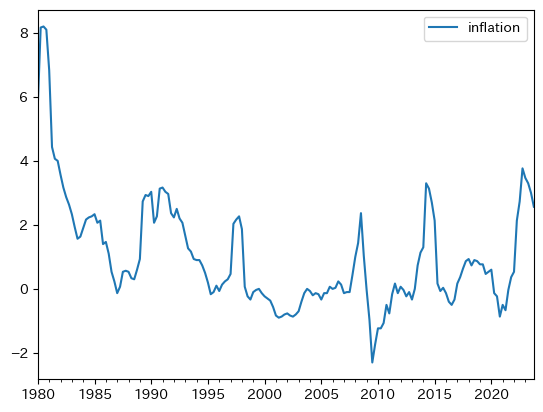

In [18]:
df.plot(y='inflation')
pass

上下しているのが，過去約35年間は非常に安定している。図から持続性が強いことがわかるが，実際に計算してみよう。

In [19]:
df.loc[:,'inflation'].autocorr()

0.9472105943180971

`0.949`は非常に高い持続性を意味しており，インフレが増加すると持続傾向にあることがわかる。次にトレンドからの乖離（％ポイント）を計算し，GDPのトレンドからの乖離と重ねて図示してみよう。

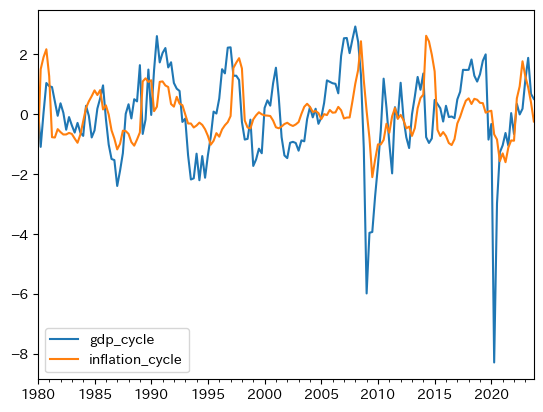

In [20]:
df['inflation_trend'] = py4macro.trend(df['inflation'])
df['inflation_cycle'] = df['inflation'] - df['inflation_trend']

df.plot(y=['gdp_cycle','inflation_cycle'])
pass

同じ方向に動く傾向が確認できる。相関係数を計算してみる。

In [21]:
df[['inflation_cycle','gdp_cycle']].corr()

,inflation_cycle,gdp_cycle
inflation_cycle,1.000000,0.347499
gdp_cycle,0.347499,1.000000


絶対値でみると失業程ではないが，正の相関性があることが確認できる。この結果から，インフレ率と失業率の負の相関が予測される。次に、自己相関係数を確認する。

In [22]:
df['inflation_cycle'].autocorr()

0.789736058894014

トレンドからの乖離も強い持続性があることを示している。

### フラット化するフィリップス曲線

まずインフレ率と失業率の散布図をプロットしよう。

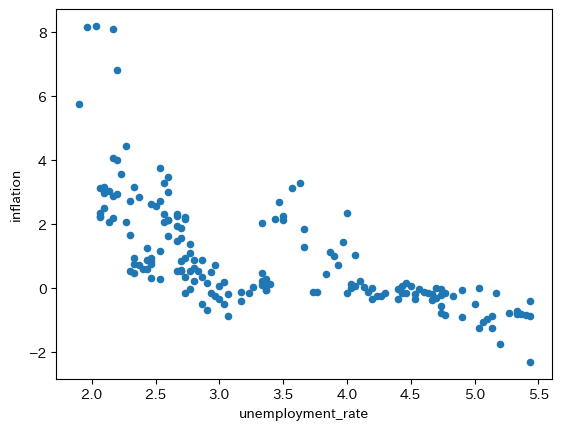

In [23]:
df.plot.scatter(x='unemployment_rate', y='inflation')
pass

右下がりであり式[](eq:11-phillips)と整合的にみえる。上の散布図に１つの曲線を描いてそれをPC曲線と呼ぶこともできるだろう。一方で，次の問題を考えてみよう。
1. 過去40年間，フィリプス曲線は変化した可能性はないのか。即ち，真のメカニズムが変わりながら生成されたデータが表示されているのではないか，という問題である。
2. 式[](eq:11-phillips)には期待インフレ率がり，また供給サイドのショックもあり得る（例えば，コロナ禍）。それらをどう考えるかという問題がある。

第二の問題を扱うことはこのサイトの範囲を超えるので，ここでは扱わず議論を進めることにする。以下では第一の問題を考察してみよう。

景気循環のマクロ経済学での短期は何ヶ月または何年以下で，長期は何年以上なのだろうか。実は，曖昧で学者・学派によって見解が別れる事になる。ここでは10年間は長期に入ると考えることにする（多くの経済学者は同意するだろう）。この考えに基づき，10年毎のデータを検討しPC曲線に変化があるかどうかを確かめることにする。

まず10年毎のデータを使うために，次のコードを使い新たな列`decade`を`df`に追加しよう。

In [24]:
df['decade'] = df.index.year // 10 * 10
df['decade']


1980-01-01    1980
1980-04-01    1980
1980-07-01    1980
1980-10-01    1980
1981-01-01    1980
              ... 
2022-10-01    2020
2023-01-01    2020
2023-04-01    2020
2023-07-01    2020
2023-10-01    2020
Name: decade, Length: 176, dtype: int32

````{admonition} コードの説明
:class: dropdown
`df.index`は行ラベルを抽出するが，その属性`.year`は行ラベルから年だけを抽出する。年を切り捨て除算演算子`//`を使い次の様に変換する
```
1980 →　198
1981 →　198
1982 →　198
...
```
更に，それぞれの数字を`*10`により`10`倍することにより，次のような変換となる。
```
1980 →　1980
1981 →　1980
1982 →　1980
...
```
それを新たな列`decade`に割り当てている。
````

新たな列と`for`ループを使い，式[](eq:11-phillips)の係数$a$と$b$を推定してみよう。大きな差が無ければ，フィリップス曲線は概ね一定だと考えることができる。

In [25]:
decade_lst = list( range(1980, 2011, 10) )         #1

a_lst = []   #2
b_lst = []   #3

for d in decade_lst:                               #4
    cond = ( df['decade'] == d )                   #5
    res = smf.ols('inflation ~ unemployment_rate', #6
                 data=df.loc[cond,:]).fit()        #7
    
    df[f'{d}年代データ'] = res.fittedvalues          #8
    a_lst.append( res.params.iloc[0] )            #9
    b_lst.append( res.params.iloc[1] )            #10

```{admonition} コードの説明
:class: dropdown

* `#1`：`1980`，`1990`，`2000`，`2010`の4つの要素からなるリストを`decade_list`に割り当てる。
* `#2`：定数項の推定値を格納する空のリスト。
* `#3`：スロープ係数の推定値を格納する空のリスト。
* `#4`：`decade_list`を使い`for`ループを開始。
* `#5`：列`decade`が`d`と等しい行のみが`True`になる条件を`cond`に割り当てる。
* `#6`：OLS推定の結果を`res`に割り当てる。
* `#7`：OLS推定に使用する`DataFrame`を指定するが，`.loc[cond,:]`を使い10年間だけのデータを抽出する。
* `#8`：`res.fittedvalues`はOLSの予測値だが，新たな列として`df`に追加している。
    * 列ラベルとして`1980年代データ`のように設定しており，下でプロットする際の凡例に使うためである。
    * `f-string`を使うために`f`を置き`{}`の中に文字列を代入している。
* `#9`：`res.params`はOLS推定値の`Series`を返すので，その0番目の要素（定数項）を`a_list`に追加している。
* `#10`：`res.params`はOLS推定値の`Series`を返すので，その1番目の要素（スロープ係数）を`b_list`に追加している。
```

結果を`print`関数を使い表示する。

In [26]:
print('--- 定数項の推定値 -------------\n')

for d, a in zip(decade_lst, a_lst):
    print(f'{d}年代：{a:>5.2f}')
    
    
print('\n--- スロープ係数の推定値 --------\n')

for d, b in zip(decade_lst, b_lst):
    print(f'{d}年代：{b:.2f}')

--- 定数項の推定値 -------------

1980年代：18.58
1990年代： 4.37
2000年代： 4.58
2010年代： 2.11

--- スロープ係数の推定値 --------

1980年代：-6.43
1990年代：-1.04
2000年代：-1.03
2010年代：-0.48


定数項の推定値もスロープ係数の推定値も変化が大きく，特に1980年代の値とそれ以降の値の差が顕著である。傾きが緩やかになっているので，PC曲線のフラット化（需給ギャップに対してのインフレ率の弾性値の低下）と呼ばれている。研究では，日本だけではなく欧米でもPC曲線のフラット化が指摘されている。プロットして確認してみよう。

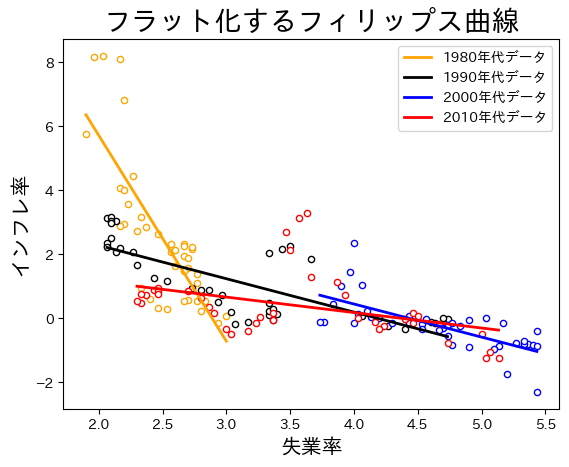

In [27]:
color_lst = ['orange','black', 'blue', 'red']    #1

#2
ax = df.head(0).plot(legend=False)

for d, c in zip(decade_lst, color_lst):
    
    cond = ( df['decade']==d )
    
    df.loc[cond,:].plot.scatter(x='unemployment_rate',
                                y='inflation',
                                edgecolor=c,      #3
                                color='white',    #4
                                legend=False,
                                ax=ax)

    df.loc[cond,:].sort_values(f'{d}年代データ').plot(
                        x='unemployment_rate',
                        y=f'{d}年代データ',  
                        color=c,          #5
                        linewidth=2,      #6
                        ax=ax,
                        )

# 軸の飾り付け
ax.set_title('フラット化するフィリップス曲線', size=20)
ax.set_xlabel('失業率', fontsize=15)
ax.set_ylabel('インフレ率', fontsize=15)
pass

```{admonition} コードの説明
:class: dropdown

* `#1`：色のリスト
    * `['orange','k', 'b', 'r']`としてもOK。
* `#2`：`.head(0)`は列ラベルだけの`DataFrame`を作成するが，それを利用して空の軸を作成し，変数`ax`に割り当てる。下に続く`for`ループを使い，`ax`にプロットする。
* `#3`：`edgecolor`は散布図の円形マーカーの縁の色を指定する引数。
* `#4`：`color`は散布図の円形マーカー色を指定する引数。
* `#5`：`color`は直線の色を指定する引数。
* `#6`：`linewidth`は直線幅を指定する引数。
```

時間が経つにつれてPC曲線は右に横滑りしていることが確認できる。失業率に対してのインフレ率の反応が鈍くなっていることを示しているが，フラット化の原因は定かではなく，活発な研究がおこなわれている。原因として次の点が指摘されている。
1. 中央銀行の政策決定の透明化や政策のアナウンスメント，フォーワード・ガイダンス（将来の政策についてのガイダンス）などにより，中央銀行の物価安定（インフレ安定）重視のスタンスが民間に十分に浸透したと考えられる。失業が変化しても，インフレ率のの安定化を図る中央銀行の政策スタンスが民間の期待に織り込まれ，インフレ率の変化は小さくなったと思われる。この解釈が正しければ，日銀は素晴らしい仕事をしたということである。
2. グローバル化や規制改革により競争環境が変化し（例えば，需要曲線の変化や寡占化），その結果，企業の価格設定行動がも変化したためである。
3. 1980年代のPC曲線の傾きは，データ上では大きく見えるが，真のPC曲線はフラットだったという解釈である。上の散布図は観測されたデータを単純にプロットしただけであり，データだけを見てもその裏にあるデータ生成メカニズムは分からない。更には，1980年代にインフレ率が急に減少しているが，インフレ率の下落はPC曲線の下方シフトとして発生したと考えられ，それがデータ上ではPC曲線の急な傾きとして観測されているに過ぎない。
4. PC曲線は直線ではなく非線形であり，失業率が高くなると傾きが緩やかになる。直感的には次のように理解できる。企業にとって価格改定にはコストがかかる。従って，インフレ率が高い場合は企業は価格改定をしないと損をするのでより頻繁に価格を上昇させる。一方，インフレ率が低いと，価格改定しない場合の損失は大きくないので，価格の変化は頻繁に起こらなくなる。

解釈１〜３によると，「真のメカニズム」が変化したと考えることができる。一方，解釈４では「真のメカニズム」は変わらないという事になる。どの解釈がより妥当なのだろうか。非常に難しい問題であり，その解明が経済学の進歩につながる事は言うまでもない。（データと整合的な解釈が複数存在することは経済学でよくあることである。）

経済学に関するジョークに，真っ暗な部屋で黒猫を探す経済学者が登場するものがある。それを模して黒猫がPC曲線だとしよう。最初に黒猫の小さな可愛い鳴き声が聞こえ，５分後にまた同じ方向から鳴き声が聞こえたとする。それだけで，黒猫がいた場所が少しでも変わったかどうかを判断するとした場合，様々な解釈が成立する。「右に10cm動いているようだ。」「いや左に5cm。」「1m程右に動いて元の位置に戻っている。」「そもそも猫は2匹いて，最初の黒猫は他の場所に移り，もう一匹の三毛猫が鳴いたのではないか。」「2回目の鳴き声は幻聴だ。」非常に難しそうである。

```{admonition} 黒猫のジョーク
:class: note, dropdown

A mathematician, a theoretical economist and an econometrician are asked to find a black cat (who doesn't really exist) in a closed room with the lights off: 
* The mathematician (数学者) gets crazy trying to find a black cat that doesn't exist inside the darkened room and ends up in a psychiatric hospital. 
* The theoretical economist (理論経済学者) is unable to catch the black cat that doesn't exist inside the darkened room, but exits the room proudly proclaiming that he can construct a model to describe all his movements with extreme accuracy. 
* The econometrician (計量経済学者，特に経済データを用いて実証研究をする学者) walks securely into the darkened room, spend one hour looking for the black cat that doesn't exits and shouts from inside the room that he has it catched by the neck.

[経済学のジョークのGoogle検索結果](https://www.google.com/search?q=economics+jokes)
```